<a href="https://colab.research.google.com/github/Rio-HEPLab/EAFEXP2024/blob/main/Simulation_Muon_Flux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# H0: Distance of top detector to generation plane
# x_gen(min,max), y_gen(min,max): Boundary of generation plane
H0 = 10.
x_gen_min = -30.
x_gen_max = 80.
y_gen_min = -30.
y_gen_max = 80.

# Lx: Detector width in x direction
# Ly: Detector width in y direction
# H: Distance of bottom detector with respect to top detector
# In cm
Lx = 50.0
Ly = 50.0
H  = 5.0

# Number of tracks to simulate
Ntracks = 1000000

costheta_power_epsilon = 0.

Probabilidade em função do ângulo zenital e azimutal:

$$
\begin{align}
dp(\theta,\phi) &= \cos^2\theta \,d\Omega \\
                &= \cos^2\theta \,d(\cos\theta) \,d\phi \\
                &= \cos^2\theta \sin\theta \,d\theta \,d\phi
\end{align}
$$

#### Simulação de Monte Carlo (MC)

$$
\begin{align}
dp(\theta,\phi) = \cos^2\theta \sin\theta \,d\theta \,d\phi
\end{align}
$$

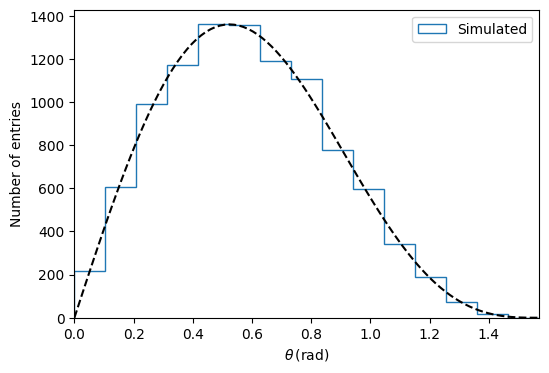

In [2]:
# Acceptance/rejection
# 1- Simulate theta according to cos^2(theta) x sin(theta) x cos(theta)

def simulate_theta( N = 1 ):

    vals = []

    for i in range( N ):
        one_theta = -999.
        while True:
            sample_theta_ = np.random.rand() * ( np.pi / 2 )
            sample_y_ = np.random.rand()
            cos2theta_ = ( np.cos( sample_theta_ ) ** ( 2 + costheta_power_epsilon ) ) * np.sin( sample_theta_ ) * np.cos( sample_theta_ )
            if sample_y_ < cos2theta_:
                one_theta = sample_theta_
                break
        vals.append( one_theta )

    return vals[0] if N == 1 else vals

vals_theta = simulate_theta( 10000 )

fig = plt.figure( figsize=(6,4) )

counts, bins, __ = plt.hist( vals_theta, range=(0,np.pi/2), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., np.pi/2, 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
# plt.plot( X__, ( integral_counts * bin_width / (1./3) ) * np.sin( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.plot( X__, ( integral_counts * bin_width / (1./4) ) * np.sin( X__ ) * np.cos( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.xlim( 0., np.pi/2 )
plt.xlabel( r'$\theta \,(\rm{rad})$' )
plt.ylabel( 'Number of entries' )
plt.legend( loc='best' )


Simulação de valores de $\cos\theta$:
$$
\begin{align}
dp(\cos\theta,\phi) = \cos^2\theta \,d(\cos\theta) \,d\phi \\
\end{align}
$$

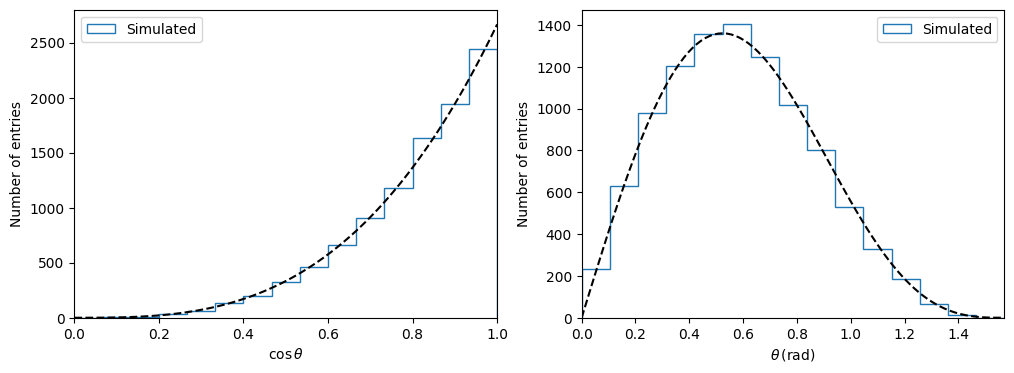

In [3]:
# Acceptance/rejection
# 2- Simulate cos(theta) according to cos^2(theta) x cos(theta)

def simulate_costheta( N = 1 ):

    vals = []

    for i in range( N ):
        one_costheta = -999.
        while True:
            sample_costheta_ = np.random.rand()
            sample_y_ = np.random.rand()
            cos2theta_ = sample_costheta_ ** ( 2 + 1 + costheta_power_epsilon )
            if sample_y_ < cos2theta_:
                one_costheta = sample_costheta_
                break
        vals.append( one_costheta )

    return vals[0] if N == 1 else vals

vals_costheta = simulate_costheta( 10000 )

# Convert to theta
vals_theta = np.arccos( vals_costheta )

# Plot as a function of cos(theta) and theta

fig, axes = plt.subplots( 1, 2, figsize=(2*6,4) )

counts, bins, __ = axes[0].hist( vals_costheta, range=(0,1), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., 1., 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
# axes[0].plot( X__, ( ( integral_counts * bin_width / (1./3) ) * X__ ** 2 ), 'k--' )
axes[0].plot( X__, ( ( integral_counts * bin_width / (1./4) ) * X__ ** 2 * X__ ), 'k--' )
axes[0].set_xlim( 0., 1. )
axes[0].set_xlabel( r'$\cos\theta$' )
axes[0].set_ylabel( 'Number of entries' )
axes[0].legend( loc='best' )

counts, bins, __ = axes[1].hist( vals_theta, range=(0,np.pi/2), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., np.pi/2, 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
# axes[1].plot( X__, ( integral_counts * bin_width / (1./3) ) * np.sin( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
axes[1].plot( X__, ( integral_counts * bin_width / (1./4) ) * np.sin( X__ ) * np.cos( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
axes[1].set_xlim( 0., np.pi/2 )
axes[1].set_xlabel( r'$\theta \,(\rm{rad})$' )
axes[1].set_ylabel( 'Number of entries' )
axes[1].legend( loc='best' )


Simulação a partir da distribuição cumulativa $F(\theta)$

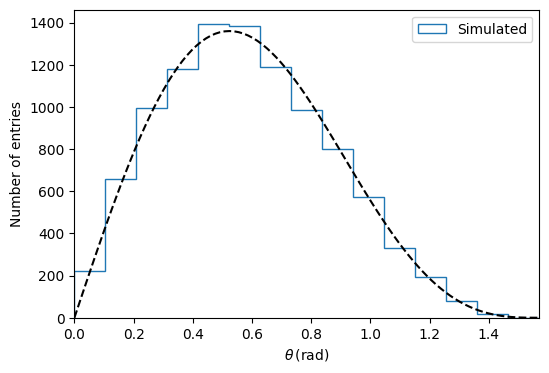

In [4]:
# # Cumulative distribution of cos^2(x)sin(x)
# def F( x ):
#     return ( 1. - np.cos( x ) ** 3 )

# Cumulative distribution of cos^2(x) x sin(x) x cos(x)
def F( x ):
    return ( 1. - np.cos( x ) ** 4 )

# Sample cumulative distribution and invert (invertion can be performed with a lookup table, not done here)
def simulate_theta_cumulative( N = 1 ):

    vals = []

    for i in range( N ):
        val_y = np.random.rand()
        # Find x such y = F(x)
        opt_sol = optimize.root_scalar( ( lambda x: F( x ) - val_y ) , bracket=(0,np.pi/2) )
        one_theta = opt_sol.root

        vals.append( one_theta )

    return vals[0] if N == 1 else vals

vals_theta = simulate_theta_cumulative( 10000 )

fig = plt.figure( figsize=(6,4) )

counts, bins, __ = plt.hist( vals_theta, range=(0,np.pi/2), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., np.pi/2, 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
# plt.plot( X__, ( integral_counts * bin_width / (1./3) ) * np.sin( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.plot( X__, ( integral_counts * bin_width / (1./4) ) * np.sin( X__ ) * np.cos( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.xlim( 0., np.pi/2 )
plt.xlabel( r'$\theta \,(\rm{rad})$' )
plt.ylabel( 'Number of entries' )
plt.legend( loc='best' )

#### Simulação das trajetórias de partículas

In [5]:
# Simulate angles and position of tracks

def random_tracks( Ntracks ):
    '''
    Generates random tracks according to a cos²(theta) propability.
    Parameters:
    Ntracks: Number of tracks to generate.
    Returns:
    Arrays of zenithal angle, azimuthal angle, x and y positions.
    '''

    theta = [] #zenital angle
    phi = [] #azimutal angle
    x = [] #position in x
    y = [] #position in y

    for i in range( 0, Ntracks ):
        if i > 0 and i % 100000 == 0:
            print ( "{} tracks processed.".format( i ) )

        one_theta = simulate_theta()

        one_phi = np.random.rand() * ( 2*np.pi - 0 )

        one_x = np.random.uniform( x_gen_min, x_gen_max )
        one_y = np.random.uniform( y_gen_min, y_gen_max )

        theta.append(one_theta)
        phi.append(one_phi)
        x.append(one_x)
        y.append(one_y)

    return theta, phi, x, y


In [6]:
theta, phi, x, y = random_tracks( Ntracks )

100000 tracks processed.
200000 tracks processed.
300000 tracks processed.
400000 tracks processed.
500000 tracks processed.
600000 tracks processed.
700000 tracks processed.
800000 tracks processed.
900000 tracks processed.


#### Propagação para o detector inferior

In [7]:
# Propagate tracks from top to bottom detector

def propagate_to_bottom(theta, phi, x0, y0, h):
    '''
    Propagates a track with given direction and initial position to a bottom plane.
    Parameters:
    theta (float): Zenital angle of the track trajectory, in radians.
    phi (float): Azimutal angle of the muon trajectory, in radians.
    x0, y0: X and Y initial track position in top plane.
    h: distance to bottom plane
    Returns:
    x and y position of the track in the bottom plane.
    '''
    d = h * np.tan( theta )
    deltaX = d * np.cos( phi )
    deltaY = d * np.sin( phi )
    x_bot, y_bot = (x0 + deltaX, y0 + deltaY)

    return x_bot, y_bot

count_all  = 0
count_det1 = 0
count_det2 = 0

theta_det1_acc  = []
phi_det1_acc    = []
x_det1_acc = []
y_det1_acc = []

theta_det2_acc  = []
phi_det2_acc    = []
x_det2_acc = []
y_det2_acc = []

for theta_, phi_, x0_, y0_ in zip(theta, phi, x, y):
    # Propagate track positions in top detector
    x_det1_prop_, y_det1_prop_ = propagate_to_bottom( theta_, phi_, x0_, y0_, H0 )
    x_det2_prop_, y_det2_prop_ = propagate_to_bottom( theta_, phi_, x0_, y0_, ( H0 + H ) )

    # Check if within acceptance of top detector
    if ( 0. < x_det1_prop_ and x_det1_prop_ < Lx ) and ( 0 < y_det1_prop_ and y_det1_prop_ < Ly ):
        count_det1 += 1
        theta_det1_acc.append( theta_ )
        phi_det1_acc.append( phi_ )
        x_det1_acc.append( x_det1_prop_ )
        y_det1_acc.append( y_det1_prop_ )
        # Check if within acceptance also of bottom detector
        if ( 0. < x_det2_prop_ and x_det2_prop_ < Lx ) and ( 0 < y_det2_prop_ and y_det2_prop_ < Ly ):
            count_det2 += 1
            theta_det2_acc.append( theta_ )
            phi_det2_acc.append( phi_ )
            x_det2_acc.append( x_det2_prop_ )
            y_det2_acc.append( y_det2_prop_ )

print ( "Number of tracks in detector 1 and 2 / detector 1: {} / {} ({})".format( count_det2, count_det1, count_det2/count_det1 ) )


Number of tracks in detector 1 and 2 / detector 1: 186457 / 206265 (0.9039681962523938)


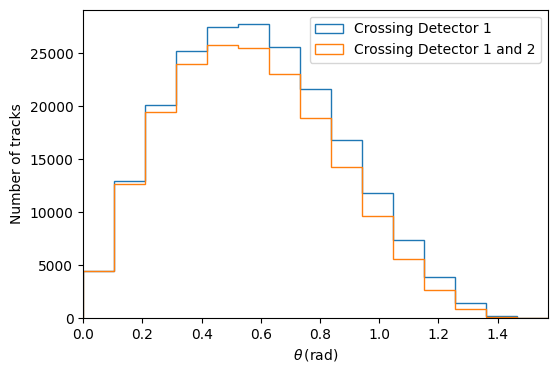

In [8]:
fig = plt.figure( figsize=(6,4) )

plt.hist( theta_det1_acc, range=(0,np.pi/2), bins=15, histtype='step', label="Crossing Detector 1" )
plt.hist( theta_det2_acc, range=(0,np.pi/2), bins=15, histtype='step', label="Crossing Detector 1 and 2" )
plt.xlim( 0., np.pi/2 )
plt.xlabel( r'$\theta \,(\rm{rad})$' )
plt.ylabel( 'Number of tracks' )
plt.legend( loc='best' )

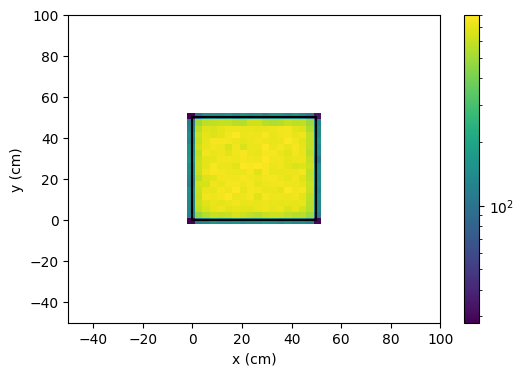

In [9]:
from matplotlib.colors import LogNorm
fig = plt.figure( figsize=(6,4) )
counts, xedges, yedges, im = plt.hist2d( x_det2_acc, y_det2_acc, bins=(50,50), range=( (-50.,100.), (-50.,100.) ), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=plt.gca())
plt.plot( [ 0., Lx, Lx, 0., 0. ], [0., 0., Ly, Ly, 0. ], 'k-' )
plt.xlim( -50, 100 )
plt.ylim( -50, 100 )
plt.xlabel( 'x (cm)' )
plt.ylabel( 'y (cm)' )
plt.show()